In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_10_05_03
NN-MODEL FILENAME:  ./models/VBKG0BIX_10_05_03_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 1
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  1


In [16]:
def mp_node_run(node_id, boundary, iteration, p_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MIN, 
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MAX ]  = boundary
    
    
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,  LENGTH_MAX, LO_GRAIN)

    my_borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = p_table
    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)

            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, my_borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = (node_id%N_ACTIONS)#np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)
                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, my_borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)

#     GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    new_max = np.array([exp_rec[:,i].max() for i in range(N_STATES)])
    new_min = np.array([exp_rec[:,i].min() for i in range(N_STATES)])
    

    if iteration >= 4: 

        old_max = np.array(boundary[:N_STATES])
        old_min = np.array(boundary[N_STATES:])

        newboundary_max = old_max
        newboundary_min = old_min

        damper = 0.6
        for i in range(N_STATES):
            newboundary_max[i] = new_max[i] if new_max[i] >= old_max[i] else (old_max[i]*damper+new_max[i]*(1-damper))
            newboundary_min[i] = new_min[i] if new_min[i] <= old_min[i] else (old_min[i]*damper+new_min[i]*(1-damper))
            
            MARGIN = 2*(newboundary_max - newboundary_min)/HI_GRAIN

        newboundary = np.concatenate((newboundary_max + MARGIN,
                                      newboundary_min - MARGIN))
    else:
        MARGIN = 2*(new_max - new_min)/HI_GRAIN
        newboundary = np.concatenate((new_max + MARGIN,
                                      new_min + MARGIN))

        
#   # CLAMP STATE VALUE BORDERS
    ##############################################
    newboundary[0] = clamp(C_POS_ABS_MIN, newboundary[0], C_POS_ABS_MAX)
    newboundary[5] = clamp(C_POS_ABS_MIN, newboundary[5], C_POS_ABS_MAX) 

    newboundary[1] = clamp(C_VEL_ABS_MIN, newboundary[1], C_VEL_ABS_MAX)
    newboundary[6] = clamp(C_VEL_ABS_MIN, newboundary[6], C_VEL_ABS_MAX) 

    newboundary[2] = clamp(P_ANG_ABS_MIN, newboundary[2], P_ANG_ABS_MAX)
    newboundary[7] = clamp(P_ANG_ABS_MIN, newboundary[7], P_ANG_ABS_MAX) 

    newboundary[3] = clamp(P_VEL_ABS_MIN, newboundary[3], P_VEL_ABS_MAX)
    newboundary[8] = clamp(P_VEL_ABS_MIN, newboundary[8], P_VEL_ABS_MAX)
    
    newboundary[4] = clamp(LENGTH_ABS_MIN, newboundary[4], LENGTH_ABS_MAX)
    newboundary[9] = clamp(LENGTH_ABS_MIN, newboundary[9], LENGTH_ABS_MAX)
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES  ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 11803.05 MiB, increment: 10684.32 MiB
Quantization TIME:  0.11 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table
q_table_list = [node_q_table]* NO_OF_NODES




ITERATION # 0
TOTAL EXPERIENCE GENERATED:   17182
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 66
TOTAL SERIAL TIMESTEPS:   17182
TOTAL PARALLEL TIMESTEPS: 66


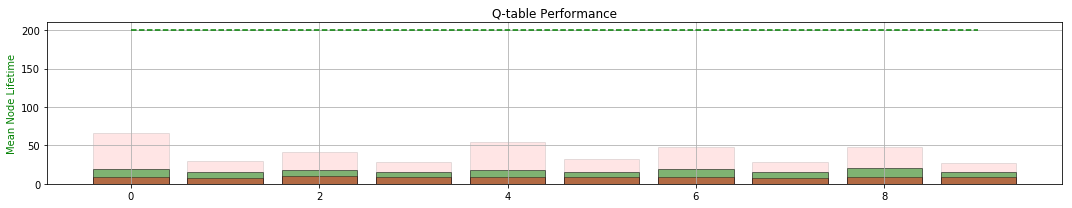

MEMORY COUNTER:  17182
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 545.435	LOSS : 523.612	LOSS : 497.631	LOSS : 523.701	LOSS : 500.836	LOSS : 484.272	LOSS : 478.318	LOSS : 479.656	LOSS : 456.344	LOSS : 455.365	LOSS : 448.780	LOSS : 462.930	LOSS : 458.661	LOSS : 451.079	LOSS : 438.685	LOSS : 448.227	LOSS : 433.259	LOSS : 440.819	LOSS : 428.583	LOSS : 423.294	
Validating... MEAN TIME:  127.585
LOSS : 430.522	LOSS : 432.063	LOSS : 453.816	LOSS : 429.000	LOSS : 429.542	LOSS : 415.842	LOSS : 426.398	LOSS : 416.602	LOSS : 418.546	LOSS : 396.716	LOSS : 416.861	LOSS : 413.639	LOSS : 423.398	LOSS : 404.471	LOSS : 414.566	LOSS : 401.637	LOSS : 406.967	LOSS : 412.004	LOSS : 402.364	LOSS : 411.778	
Validating... MEAN TIME:  131.1
LOSS : 418.716	LOSS : 426.701	LOSS : 405.048	LOSS : 394.122	LOSS : 404.220	LOSS : 407.451	LOSS : 416.400	LOSS : 402.811	LOSS : 407.224	LOSS : 404.000	LOSS : 392.514	LOSS : 396.190	LOSS : 399.675	LOSS : 406.521	LOSS : 402.674	LOSS : 424.278	LOSS : 425

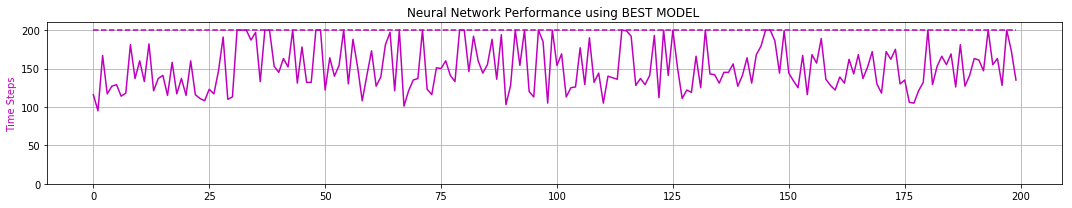

0 -max- [ 0.089  0.652  0.223  2.825  0.277]
0 -min- [-0.384 -1.677 -0.051 -0.287  0.275]

peak memory: 12021.71 MiB, increment: 10671.18 MiB
Quantization TIME:  0.1 minutes
1 -max- [ 0.243  1.815  0.062  0.268  0.327]
1 -min- [-0.035 -0.231 -0.197 -2.519  0.278]

peak memory: 12233.50 MiB, increment: 10688.43 MiB
Quantization TIME:  0.1 minutes
2 -max- [ 0.102  0.712  0.223  2.643  0.377]
2 -min- [-0.266 -1.473 -0.059 -0.314  0.328]

peak memory: 12664.27 MiB, increment: 10924.68 MiB
Quantization TIME:  0.11 minutes
3 -max- [ 0.228  1.894  0.063  0.276  0.427]
3 -min- [-0.035 -0.280 -0.196 -2.546  0.378]

peak memory: 12603.37 MiB, increment: 10667.04 MiB
Quantization TIME:  0.11 minutes
4 -max- [ 0.075  0.663  0.224  2.806  0.477]
4 -min- [-0.278 -1.634 -0.071 -0.301  0.429]

peak memory: 12833.20 MiB, increment: 10701.58 MiB
Quantization TIME:  0.11 minutes
5 -max- [ 0.236  1.903  0.061  0.262  0.527]
5 -min- [-0.035 -0.211 -0.197 -2.579  0.478]

peak memory: 13221.76 MiB, increment

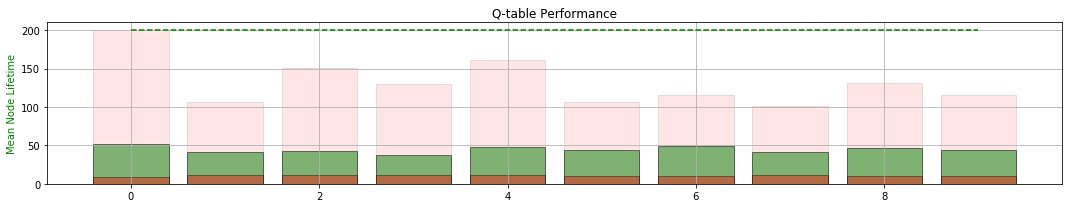

MEMORY COUNTER:  62064
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 364.372	LOSS : 358.045	LOSS : 367.276	LOSS : 368.142	LOSS : 367.407	LOSS : 367.985	LOSS : 356.580	LOSS : 344.949	LOSS : 345.537	LOSS : 351.442	LOSS : 355.376	LOSS : 350.934	LOSS : 349.338	LOSS : 338.692	LOSS : 338.697	LOSS : 334.694	LOSS : 325.158	LOSS : 332.505	LOSS : 322.525	LOSS : 321.839	
Validating... MEAN TIME:  164.88
LOSS : 304.174	LOSS : 316.698	LOSS : 314.816	LOSS : 302.047	LOSS : 316.286	LOSS : 305.600	LOSS : 305.413	LOSS : 309.609	LOSS : 303.118	LOSS : 316.062	LOSS : 315.370	LOSS : 314.044	LOSS : 301.628	LOSS : 308.925	LOSS : 299.437	LOSS : 308.022	LOSS : 304.426	LOSS : 317.015	LOSS : 301.603	LOSS : 313.982	
Validating... MEAN TIME:  168.335
LOSS : 308.989	LOSS : 318.745	LOSS : 304.956	LOSS : 293.824	LOSS : 311.843	LOSS : 326.179	LOSS : 317.618	LOSS : 324.356	LOSS : 303.055	LOSS : 307.065	LOSS : 311.990	LOSS : 297.042	LOSS : 309.730	LOSS : 310.966	LOSS : 319.009	LOSS : 317.747	LOSS : 31

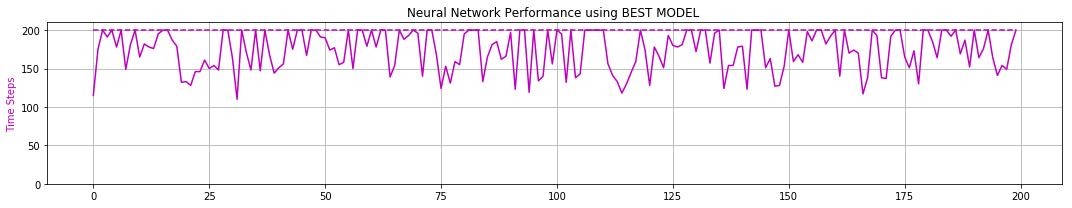

0 -max- [ 1.070  2.000  0.224  2.689  0.277]
0 -min- [-0.379 -1.424 -0.067 -1.330  0.275]

peak memory: 13995.88 MiB, increment: 10678.32 MiB
Quantization TIME:  0.1 minutes
1 -max- [ 0.459  1.774  0.069  1.687  0.326]
1 -min- [-0.732 -1.534 -0.196 -2.319  0.278]

peak memory: 14372.17 MiB, increment: 10859.90 MiB
Quantization TIME:  0.1 minutes
2 -max- [ 0.776  1.850  0.230  2.891  0.377]
2 -min- [-0.900 -1.559 -0.181 -1.078  0.328]

peak memory: 14494.81 MiB, increment: 10786.48 MiB
Quantization TIME:  0.11 minutes
3 -max- [ 0.421  1.765  0.062  1.269  0.427]
3 -min- [-0.662 -1.525 -0.196 -2.244  0.378]

peak memory: 14735.32 MiB, increment: 10831.19 MiB
Quantization TIME:  0.11 minutes
4 -max- [ 1.013  1.812  0.222  2.528  0.477]
4 -min- [-0.144 -1.271 -0.033 -1.339  0.428]

peak memory: 14817.49 MiB, increment: 10718.85 MiB
Quantization TIME:  0.11 minutes
5 -max- [ 0.435  1.557  0.063  1.495  0.527]
5 -min- [-0.921 -1.532 -0.196 -2.116  0.478]

peak memory: 15079.38 MiB, increment

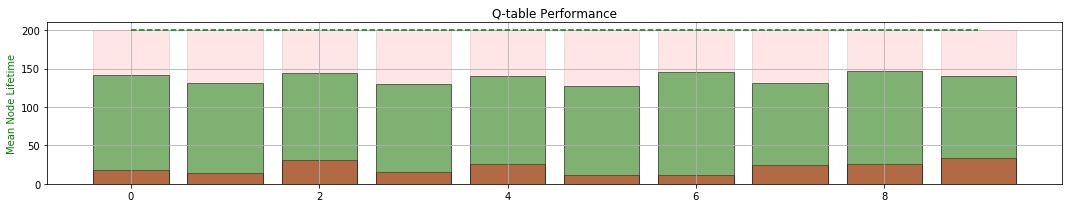

MEMORY COUNTER:  199897
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 166.809	LOSS : 155.700	LOSS : 158.920	LOSS : 157.817	LOSS : 155.313	LOSS : 162.222	LOSS : 150.771	LOSS : 148.023	LOSS : 147.051	LOSS : 150.777	LOSS : 142.975	LOSS : 161.205	LOSS : 134.698	LOSS : 135.444	LOSS : 145.688	LOSS : 151.626	LOSS : 158.725	LOSS : 170.477	LOSS : 158.083	LOSS : 155.878	
Validating... MEAN TIME:  188.66
LOSS : 146.854	LOSS : 152.119	LOSS : 149.600	LOSS : 141.573	LOSS : 138.909	LOSS : 153.571	LOSS : 148.398	LOSS : 154.250	LOSS : 149.356	LOSS : 156.478	LOSS : 144.134	LOSS : 146.285	LOSS : 149.109	LOSS : 155.857	LOSS : 159.566	LOSS : 138.116	LOSS : 145.832	LOSS : 162.138	LOSS : 156.713	LOSS : 146.621	
Validating... MEAN TIME:  192.235
LOSS : 148.711	LOSS : 149.762	LOSS : 156.777	LOSS : 147.615	LOSS : 142.982	LOSS : 148.023	LOSS : 155.753	LOSS : 154.747	LOSS : 159.258	LOSS : 154.269	LOSS : 140.954	LOSS : 150.287	LOSS : 147.704	LOSS : 157.606	LOSS : 155.899	LOSS : 155.183	LOSS : 1

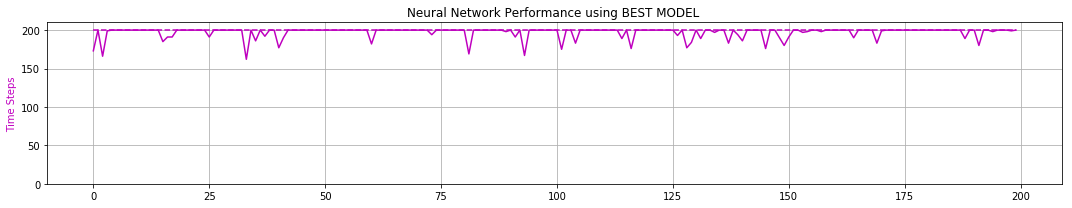

0 -max- [ 2.222  2.811  0.230  1.865  0.277]
0 -min- [-1.392 -1.946 -0.188 -1.776  0.275]

peak memory: 14132.61 MiB, increment: 10761.38 MiB
Quantization TIME:  0.11 minutes
1 -max- [ 2.269  2.776  0.230  1.820  0.327]
1 -min- [-1.345 -1.815 -0.188 -1.682  0.279]

peak memory: 14276.80 MiB, increment: 10710.08 MiB
Quantization TIME:  0.11 minutes
2 -max- [ 2.104  2.635  0.230  2.262  0.377]
2 -min- [-1.433 -1.829 -0.188 -1.574  0.328]

peak memory: 14435.48 MiB, increment: 10673.47 MiB
Quantization TIME:  0.1 minutes
3 -max- [ 2.108  2.636  0.230  1.807  0.427]
3 -min- [-1.346 -1.932 -0.188 -1.756  0.378]

peak memory: 14762.86 MiB, increment: 10806.09 MiB
Quantization TIME:  0.11 minutes
4 -max- [ 2.087  2.636  0.230  2.195  0.477]
4 -min- [-1.366 -1.662 -0.188 -1.247  0.428]

peak memory: 15063.07 MiB, increment: 10910.75 MiB
Quantization TIME:  0.11 minutes
5 -max- [ 1.990  2.427  0.229  1.628  0.527]
5 -min- [-1.295 -1.794 -0.188 -1.625  0.478]

peak memory: 15113.29 MiB, incremen

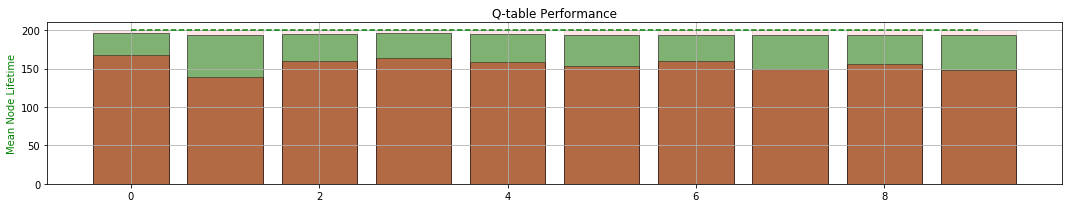

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 49.976	LOSS : 53.222	LOSS : 49.374	LOSS : 52.920	LOSS : 47.564	LOSS : 58.072	LOSS : 54.081	LOSS : 61.700	LOSS : 52.671	LOSS : 57.171	LOSS : 50.160	LOSS : 61.341	LOSS : 51.588	LOSS : 54.037	LOSS : 41.037	LOSS : 69.542	LOSS : 46.702	LOSS : 53.268	LOSS : 54.461	LOSS : 55.608	
Validating... MEAN TIME:  196.86
LOSS : 53.819	LOSS : 62.155	LOSS : 48.772	LOSS : 50.328	LOSS : 50.943	LOSS : 54.984	LOSS : 49.582	LOSS : 50.877	LOSS : 48.976	LOSS : 51.363	LOSS : 60.737	LOSS : 54.444	LOSS : 48.929	LOSS : 57.066	LOSS : 52.417	LOSS : 49.978	LOSS : 52.336	LOSS : 51.840	LOSS : 55.995	LOSS : 63.360	
Validating... MEAN TIME:  200.0
LOSS : 48.494	LOSS : 47.396	LOSS : 46.806	LOSS : 48.536	LOSS : 50.189	LOSS : 53.834	LOSS : 54.009	LOSS : 51.813	LOSS : 48.736	LOSS : 58.385	LOSS : 42.881	LOSS : 46.742	LOSS : 44.082	LOSS : 45.475	LOSS : 61.332	LOSS : 43.784	LOSS : 50.912	LOSS : 55.186	LOSS : 48.372	LOSS : 61.735	
Validatin

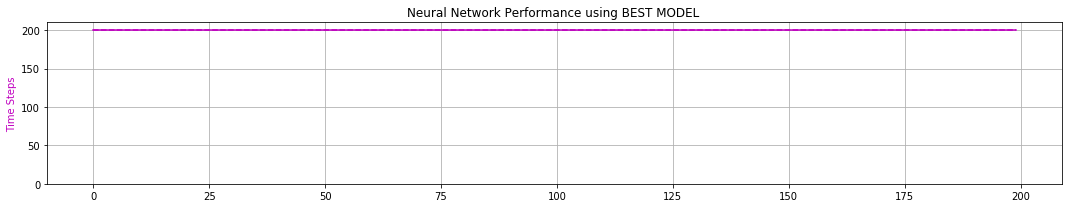

0 -max- [ 2.600  2.843  0.217  1.649  0.277]
0 -min- [-1.692 -1.996 -0.189 -1.348  0.275]

peak memory: 14104.49 MiB, increment: 10713.12 MiB
Quantization TIME:  0.11 minutes
1 -max- [ 2.600  2.847  0.183  1.581  0.327]
1 -min- [-2.009 -2.160 -0.191 -1.207  0.278]

peak memory: 14488.25 MiB, increment: 10901.66 MiB
Quantization TIME:  0.11 minutes
2 -max- [ 2.600  2.870  0.230  1.467  0.376]
2 -min- [-1.960 -2.311 -0.188 -1.423  0.328]

peak memory: 14504.61 MiB, increment: 10722.46 MiB
Quantization TIME:  0.11 minutes
3 -max- [ 2.600  2.868  0.180  1.802  0.427]
3 -min- [-2.051 -2.350 -0.191 -1.422  0.377]

peak memory: 14786.00 MiB, increment: 10809.35 MiB
Quantization TIME:  0.11 minutes
4 -max- [ 2.600  2.875  0.230  1.673  0.477]
4 -min- [-2.057 -2.341 -0.188 -1.332  0.428]

peak memory: 15069.54 MiB, increment: 10896.57 MiB
Quantization TIME:  0.11 minutes
5 -max- [ 2.600  2.860  0.193  1.519  0.527]
5 -min- [-1.957 -2.259 -0.190 -1.217  0.478]

peak memory: 15039.66 MiB, increme

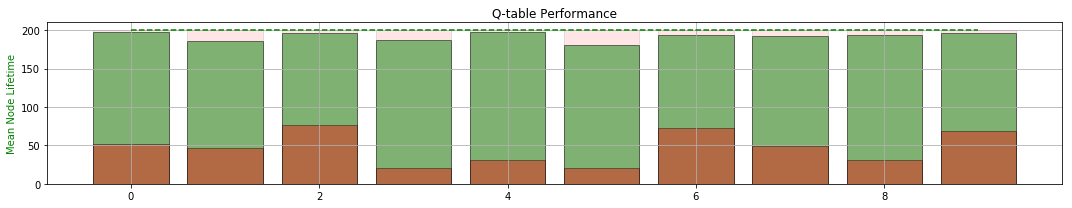

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 48.078	LOSS : 57.682	LOSS : 66.436	LOSS : 61.349	LOSS : 61.929	LOSS : 56.486	LOSS : 58.063	LOSS : 53.509	LOSS : 55.385	LOSS : 65.480	LOSS : 58.093	LOSS : 60.672	LOSS : 62.849	LOSS : 49.800	LOSS : 61.586	LOSS : 58.225	LOSS : 48.801	LOSS : 54.124	LOSS : 62.507	LOSS : 55.066	
Validating... MEAN TIME:  129.81
LOSS : 59.944	LOSS : 59.967	LOSS : 52.158	LOSS : 64.470	LOSS : 63.686	LOSS : 53.027	LOSS : 55.531	LOSS : 50.914	LOSS : 55.438	LOSS : 62.867	LOSS : 56.312	LOSS : 67.230	LOSS : 47.992	LOSS : 53.123	LOSS : 55.690	LOSS : 56.732	LOSS : 57.109	LOSS : 59.510	LOSS : 58.147	LOSS : 60.381	
Validating... MEAN TIME:  123.985
LOSS : 67.322	LOSS : 63.335	LOSS : 53.779	LOSS : 56.445	LOSS : 54.623	LOSS : 66.461	LOSS : 63.090	LOSS : 57.858	LOSS : 67.306	LOSS : 63.700	LOSS : 57.537	LOSS : 62.965	LOSS : 58.511	LOSS : 57.231	LOSS : 68.595	LOSS : 66.753	LOSS : 64.795	LOSS : 65.281	LOSS : 62.461	LOSS : 61.828	
Validat

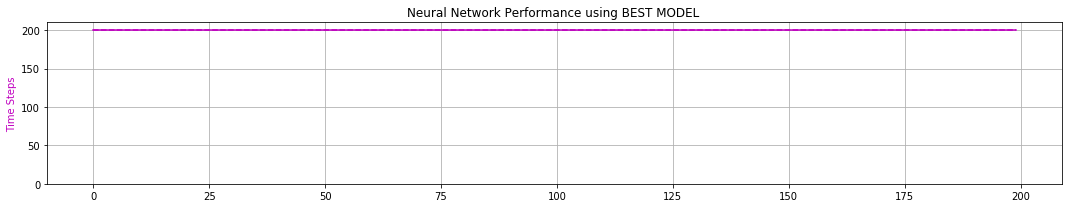

0 -max- [ 1.892  4.073  0.250  4.827  0.561]
0 -min- [-1.915 -4.060 -0.250 -4.954  0.275]

peak memory: 15162.80 MiB, increment: 10736.34 MiB
Quantization TIME:  0.11 minutes
1 -max- [ 1.839  4.003  0.234  4.831  0.579]
1 -min- [-1.940 -4.123 -0.250 -5.022  0.275]

peak memory: 15287.68 MiB, increment: 10665.74 MiB
Quantization TIME:  0.11 minutes
2 -max- [ 1.850  4.209  0.250  4.818  0.599]
2 -min- [-1.927 -4.082 -0.250 -4.953  0.281]

peak memory: 15632.02 MiB, increment: 10814.53 MiB
Quantization TIME:  0.11 minutes
3 -max- [ 1.843  4.057  0.233  4.816  0.619]
3 -min- [-1.981 -4.135 -0.250 -4.935  0.301]

peak memory: 15908.35 MiB, increment: 10895.58 MiB
Quantization TIME:  0.11 minutes
4 -max- [ 1.889  4.080  0.250  4.831  0.639]
4 -min- [-1.925 -4.071 -0.250 -4.954  0.321]

peak memory: 15877.66 MiB, increment: 10669.34 MiB
Quantization TIME:  0.11 minutes
5 -max- [ 1.851  4.002  0.232  4.824  0.659]
5 -min- [-1.982 -4.123 -0.250 -4.929  0.341]

peak memory: 16218.27 MiB, increme

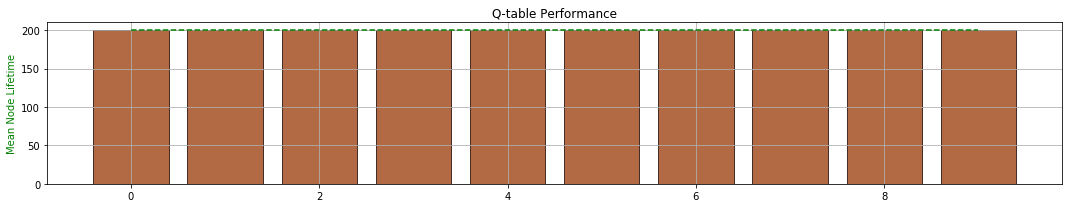

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)
        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        

    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    if iteration >= 4:
        for node_id in range(NO_OF_NODES):
            # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX,LENGTH_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN,LENGTH_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")

            # CREATE STATE COMBINATIONS
            ###############################################
            node_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN],
                                                [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX],
                                                [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES])
            ###############################################
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    else:
        for node_id in range(NO_OF_NODES):

            # PRINT STATE VALUE BORDERS AS REQUESTED BY THE NODE
            ###############################################
            [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
             C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
            ###############################################
            print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
            print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
            print("")
            #############################################################################################################################################
            node_state_combinations = init_state_combinations
            start = timeit.default_timer()
            # GET Q-VALUES 
            %memit q_table_list[node_id] = best_dqn.get_greedy_action(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)
            node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX,LENGTH_ABS_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]
            stop = timeit.default_timer()
            print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
            #############################################################################################################################################

    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1066.0
Total Serial Timesteps   :  786441.0
Speed-up                 :  737.75


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS 200   5    1066     786441     737.75
